In [1]:
pip install numpy 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas scipy py_vollib_vectorized plotly

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 5.6 MB/s eta 0:00:00
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62830 sha256=18e8d6caae48c8613e5a49cd095be3695538f1373cfe27f417aafca5b1476ce9
  Stored in directory: /Users/sahajjhajharia/Library/Caches/pip/wheels/5f/8c/ab/bbc3a2b0e6ae83633bb99f960459a2ab960b4672c7440ff4ef
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24452 sha256=31f35c62129bbc6b5bcfd42e1627a7ae93a2696961d289af06a660a293dedf76
  Stored in directory: /Users/sahajjhajharia/Library/Caches/pip/wheels/c3/c6/50/415aabc2033e7651cc8cc590bd01c5f23f9050328f6016d6a5
Successfully built py-vollib py-lets-be-rational
Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd 
import numpy as np 
from scipy.interpolate import interp1d
from py_vollib_vectorized import vectorized_implied_volatility
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [83]:
data_file = 'spy_options_2025-06-11.csv'
risk_free_rate = 0.05

In [85]:

#loading and preparing data 

df = pd.read_csv (data_file)

#converting dates to datetime objects 

df['quote_date'] = pd.to_datetime(df['quote_date'])
df['expiration'] = pd.to_datetime(df['expiration'])

#calculate time to expiry in years 
df['t_to_exp'] = df['expiration']-df['quote_date']
df['time_to_expiry'] = df['t_to_exp'].dt.days / 365

#calculating mid price for options 

df['mid_price'] = (df['bid']+df['ask']) / 2.0

#filtering out illiquid options 
df = df[df['bid'] >0]
df = df[df['time_to_expiry']>0]

print ("data loaded and prepared")
print (df.head())

data loaded and prepared
   quote_date expiration  strike option_type     bid     ask  \
92 2025-06-11 2025-06-12   435.0           C  163.95  166.71   
93 2025-06-11 2025-06-12   480.0           C  118.95  121.23   
94 2025-06-11 2025-06-12   500.0           C   98.96  101.74   
95 2025-06-11 2025-06-12   530.0           C   69.77   71.25   
96 2025-06-11 2025-06-12   540.0           C   59.77   61.33   

    underlying_price t_to_exp  time_to_expiry  mid_price  
92        601.400024   1 days         0.00274     165.33  
93        601.400024   1 days         0.00274     120.09  
94        601.400024   1 days         0.00274     100.35  
95        601.400024   1 days         0.00274      70.51  
96        601.400024   1 days         0.00274      60.55  


In [87]:


#calculating implied volatility 

df['iv'] = vectorized_implied_volatility ( price= df['mid_price'].values , S = df['underlying_price'].values, K= df['strike'].values, t= df['time_to_expiry'].values , r= risk_free_rate , flag = df['option_type'].str.lower().values)

#cleaning it up 

df = df.dropna(subset=['iv'])

print ("\n Implied Volatility Calculated:") 
print (df[['expiration', 'strike', 'mid_price','iv']].head())


 Implied Volatility Calculated:
   expiration  strike  mid_price        iv
92 2025-06-12   435.0     165.33  0.402581
93 2025-06-12   480.0     120.09  0.389911
94 2025-06-12   500.0     100.35  0.377217
95 2025-06-12   530.0      70.51  0.364498
96 2025-06-12   540.0      60.55  0.361440


/opt/anaconda3/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 514, 515, 516, 517, 518, 519, 520, 5

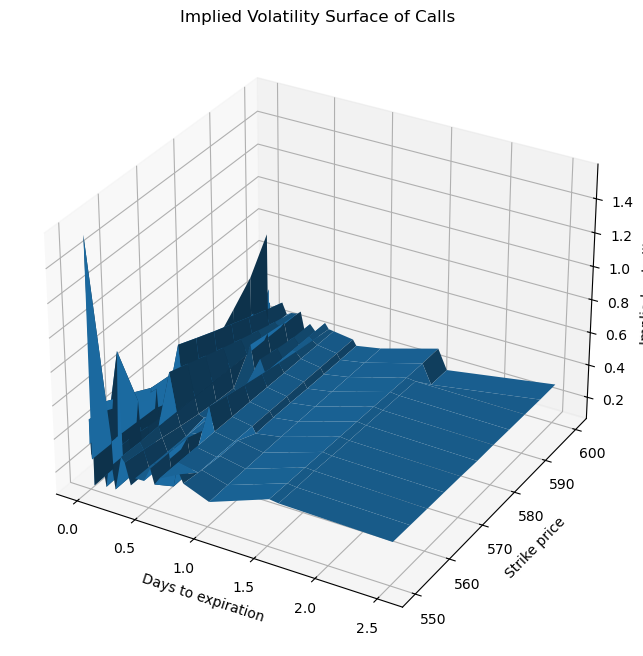

In [91]:
# pivot the dataframe
surface = (
    df[['time_to_expiry', 'strike', 'iv']]
    .pivot_table(values='iv', index='strike', columns='time_to_expiry')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Implied Volatility Surface of Calls')

# plot
ax.plot_surface(X, Y, z)

In [97]:
def calculate_variance_strike(chain_for_one_expiry):
    """Calculates the variance strike for a single expiration date's option chain."""
    
    # Get constants from the first row (they are all the same for one chain)
    T = chain_for_one_expiry['time_to_expiry'].iloc[0]
    S = chain_for_one_expiry['underlying_price'].iloc[0]
    
    # Calculate forward price F
    F = S * np.exp(risk_free_rate * T)
    
    # Find K0, the strike price immediately below the forward price F
    # We will use puts for K < K0 and calls for K > K0
    K0 = chain_for_one_expiry[chain_for_one_expiry['strike'] <= F]['strike'].max()
    
    # Separate OTM puts and calls
    otm_puts = chain_for_one_expiry[(chain_for_one_expiry['option_type'] == 'P') & (chain_for_one_expiry['strike'] < K0)].sort_values('strike')
    otm_calls = chain_for_one_expiry[(chain_for_one_expiry['option_type'] == 'C') & (chain_for_one_expiry['strike'] > K0)].sort_values('strike')
    atm_options = chain_for_one_expiry[chain_for_one_expiry['strike'] == K0]
    
    # Contribution from OTM Puts and Calls
    sum_puts = 0
    # Calculate delta K for puts
    if not otm_puts.empty:
      otm_puts['delta_K'] = otm_puts['strike'].diff().fillna(otm_puts['strike'].iloc[0]) # Approximation for first strike
      sum_puts = np.sum((otm_puts['delta_K'] / otm_puts['strike']**2) * otm_puts['mid_price'])

    sum_calls = 0
    # Calculate delta K for calls
    if not otm_calls.empty:
      otm_calls['delta_K'] = otm_calls['strike'].diff().fillna(0) # Approximation
      sum_calls = np.sum((otm_calls['delta_K'] / otm_calls['strike']**2) * otm_calls['mid_price'])
      
    # Contribution from the ATM option (average of call and put)
    atm_price = atm_options['mid_price'].mean()
    atm_delta_K = otm_calls['strike'].min() - otm_puts['strike'].max() if not otm_calls.empty and not otm_puts.empty else 0
    sum_atm = (atm_delta_K / K0**2) * atm_price

    # VIX formula calculation
    total_sum = sum_puts + sum_calls + sum_atm
    variance = (2 / T) * total_sum - (1 / T) * (F / K0 - 1)**2
    
    # Return as volatility (standard deviation) in percent
    return np.sqrt(variance) * 100

results = []
for expiry_date, chain in df.groupby('expiration'):
    var_strike = calculate_variance_strike(chain)
    results.append({
        'Expiration': expiry_date.date(),
        'Days': int(chain['time_to_expiry'].iloc[0] * 365.25),
        'Variance_Strike_Vol': var_strike
    })

results_df = pd.DataFrame(results)
print("\nCalculated Variance Swap Strikes:")
print(results_df)

# Creating a variance curve
var_curve_f = interp1d(results_df['Days'], results_df['Variance_Strike_Vol'], kind='linear', fill_value="extrapolate")

# Example: Get the 30-day variance strike vol
print(f"\nInterpolated 30-day Vol: {var_curve_f(30):.2f}%")


Calculated Variance Swap Strikes:
    Expiration  Days  Variance_Strike_Vol
0   2025-06-12     1                  NaN
1   2025-06-13     2            24.243358
2   2025-06-16     5            24.457012
3   2025-06-17     6            22.620405
4   2025-06-18     7             7.239479
5   2025-06-20     9            19.382851
6   2025-06-23    12            20.727806
7   2025-06-27    16            34.053721
8   2025-06-30    19            19.518062
9   2025-07-03    22            20.308571
10  2025-07-11    30            61.715556
11  2025-07-18    37            19.040763
12  2025-07-25    44            49.891691
13  2025-07-31    50            21.047010
14  2025-08-15    65            20.768181
15  2025-08-29    79            22.321008
16  2025-09-19   100            22.118628
17  2025-09-30   111            22.531160
18  2025-10-17   128            26.534495
19  2025-10-31   142            23.475237
20  2025-11-28   170            27.511427
21  2025-12-19   191            23.078800

/var/folders/pr/2b_15lfs21j267rj2lp81j7c0000gn/T/ipykernel_62370/2927547354.py:43: RuntimeWarning:

invalid value encountered in sqrt

